En este notebook vamos a aplicar la metodología de Holt-Winters al modelado de la serie temporal de movilidad en provincia de Alicante.

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

Leemos el fichero con datos de movilidad en provincia de Alicante en octubre y noviembre 2020 que hemos creado y guardado de manera explicada en el notebook anterior.

In [18]:
alicante_oct = pd.read_csv('./octubre/3_octubre.csv')
alicante_nov = pd.read_csv('./noviembre/3_noviembre.csv') 

Para trabajar con la serie temporal necesitamos que los datos tengan el índice de tipo DateTimeIndex. En la tabla "alicante_oct" hay 744 observaciones y en "alicante_nov" 720 observaciones con el intervalo de una hora. Creamos el índice para la tabla.

In [12]:
idx = pd.date_range('10/1/2020', periods=744 + 720, freq='h')
idx

DatetimeIndex(['2020-10-01 00:00:00', '2020-10-01 01:00:00',
               '2020-10-01 02:00:00', '2020-10-01 03:00:00',
               '2020-10-01 04:00:00', '2020-10-01 05:00:00',
               '2020-10-01 06:00:00', '2020-10-01 07:00:00',
               '2020-10-01 08:00:00', '2020-10-01 09:00:00',
               ...
               '2020-11-30 14:00:00', '2020-11-30 15:00:00',
               '2020-11-30 16:00:00', '2020-11-30 17:00:00',
               '2020-11-30 18:00:00', '2020-11-30 19:00:00',
               '2020-11-30 20:00:00', '2020-11-30 21:00:00',
               '2020-11-30 22:00:00', '2020-11-30 23:00:00'],
              dtype='datetime64[ns]', length=1464, freq='H')

Creamos una tabla nueva con el índice requerido. Añadimos los datos del fichero.

In [89]:
ts = pd.DataFrame(index=idx)

viajes = np.append(np.array(alicante_oct['viajes_km']),np.array(alicante_nov['viajes_km']) )

ts['movilidad']=viajes
ts

,movilidad
2020-10-01 00:00:00,462730.538
2020-10-01 01:00:00,387049.918
2020-10-01 02:00:00,317706.331
2020-10-01 03:00:00,367035.598
2020-10-01 04:00:00,636404.198
...,...
2020-11-30 19:00:00,1767450.360
2020-11-30 20:00:00,1367525.670
2020-11-30 21:00:00,986590.410
2020-11-30 22:00:00,718019.963


In [30]:
ts.index

DatetimeIndex(['2020-10-01 00:00:00', '2020-10-01 01:00:00',
               '2020-10-01 02:00:00', '2020-10-01 03:00:00',
               '2020-10-01 04:00:00', '2020-10-01 05:00:00',
               '2020-10-01 06:00:00', '2020-10-01 07:00:00',
               '2020-10-01 08:00:00', '2020-10-01 09:00:00',
               ...
               '2020-11-30 14:00:00', '2020-11-30 15:00:00',
               '2020-11-30 16:00:00', '2020-11-30 17:00:00',
               '2020-11-30 18:00:00', '2020-11-30 19:00:00',
               '2020-11-30 20:00:00', '2020-11-30 21:00:00',
               '2020-11-30 22:00:00', '2020-11-30 23:00:00'],
              dtype='datetime64[ns]', length=1464, freq='H')

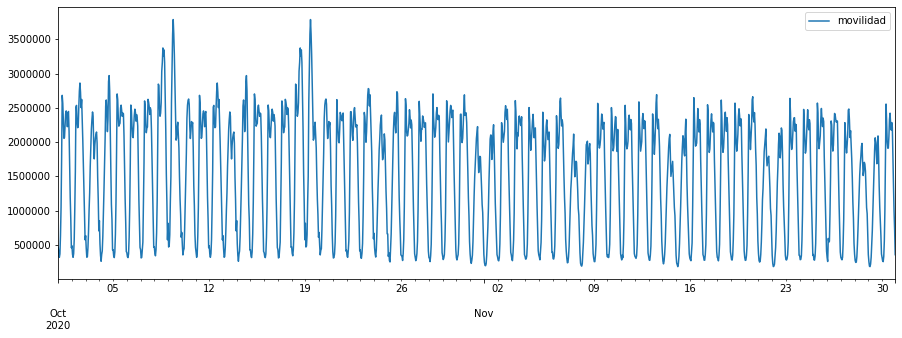

In [31]:
ts.plot(figsize=(15,5));

Descomponemos la serie y visualizamos los componentes.

In [32]:
ss_decomposition = seasonal_decompose(x=ts, model='additive')
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

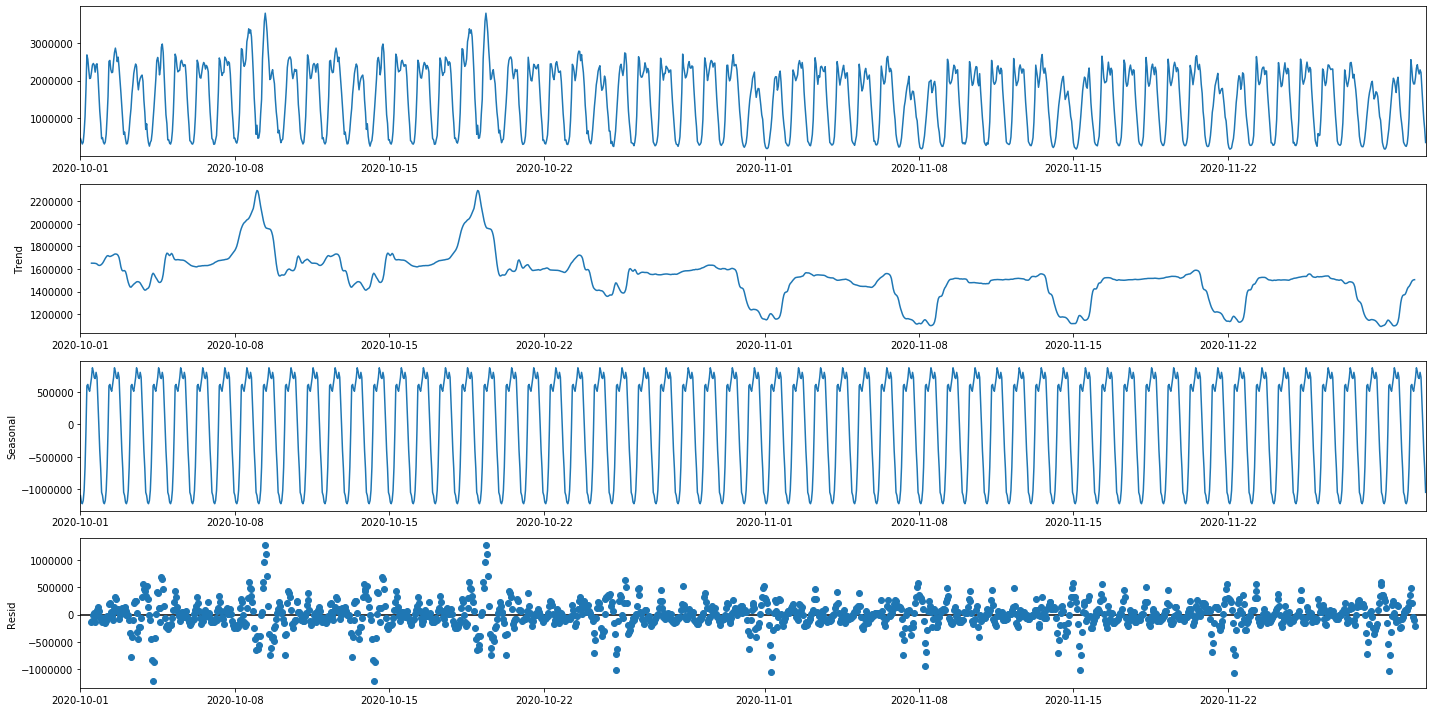

In [36]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

ss_decomposition.plot();

A diferencia de la tendencia de noviembre, la tendencia en octubre tiene dos picos: el 9 y el 19 de octubre.  El 9 es el Dia de la Comunidad Valenciana (un dia festivo). El dia 19 fue lunes, tal vez, tuve una alta movilidad por acabar la puente del Pilar?

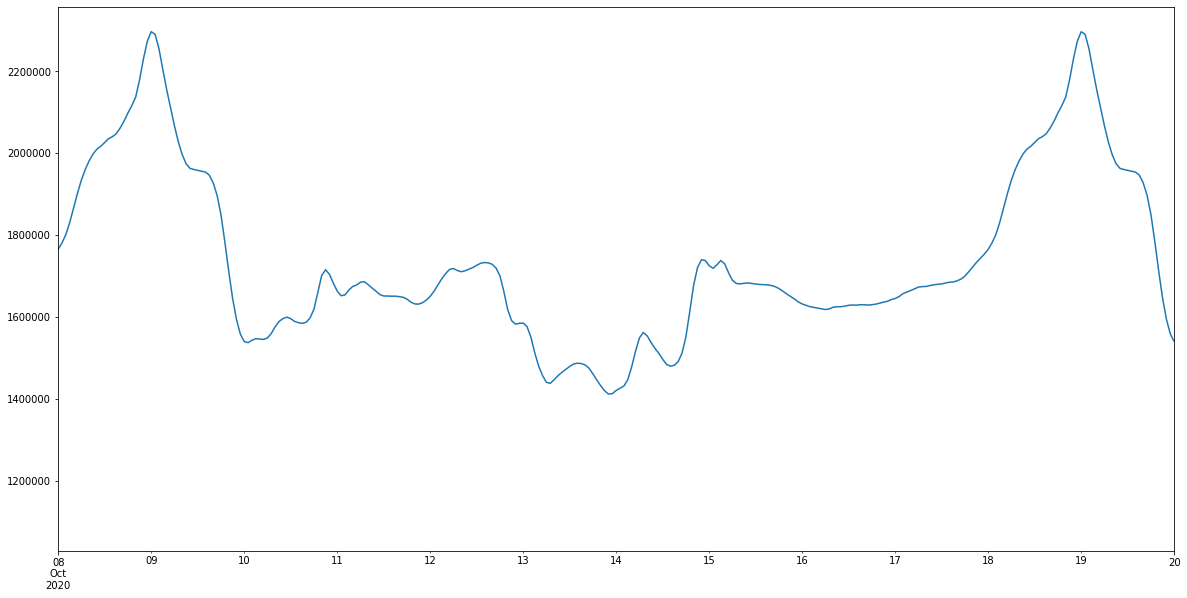

In [51]:
estimated_trend.plot(xlim=['2020-10-08','2020-10-20']);

Visualizamos una semana en octubre. Así podemos ver que movilidad tiene tres picos en dias laborales y dos por sabados y domingos.

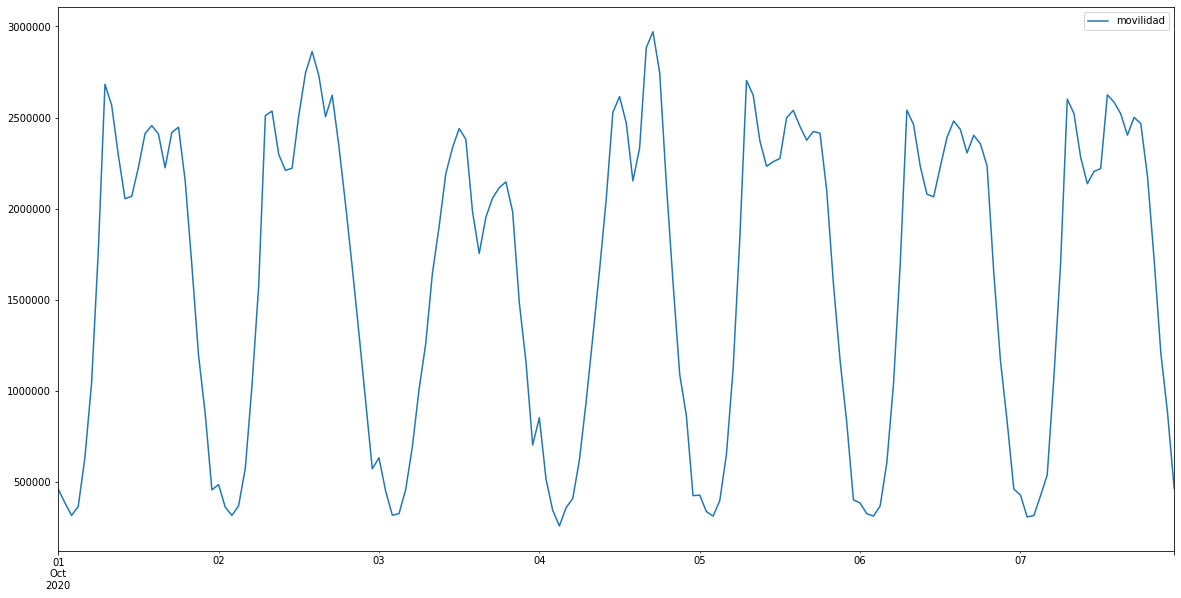

In [38]:
ts[:7*24].plot();

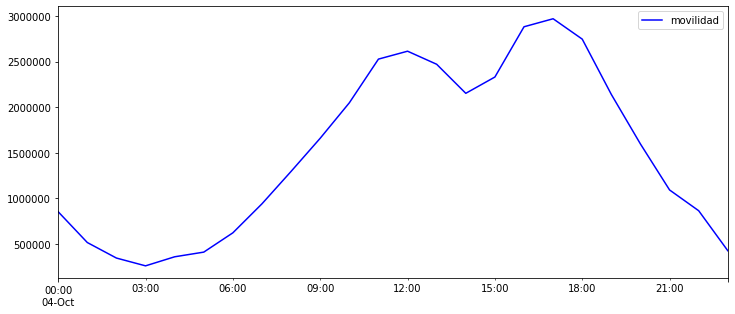

In [44]:
# Domingo, 4 de octubre
ts[72:96].plot(figsize=(12,5), c='blue');

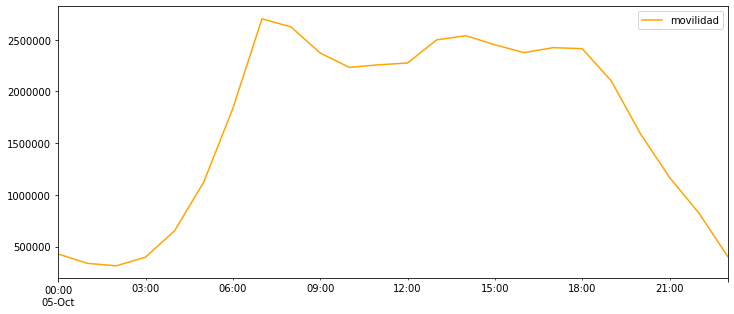

In [47]:
# Lunes, 5 de octubre
ts[96:120].plot(figsize=(12,5), c='orange');

In [48]:
df =pd.DataFrame(index= np.arange(24), columns=['Domingo', 'Lunes'])
df.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64')

In [49]:
df['Domingo']=np.array(ts[72:96])
df['Lunes']=np.array(ts[96:120])

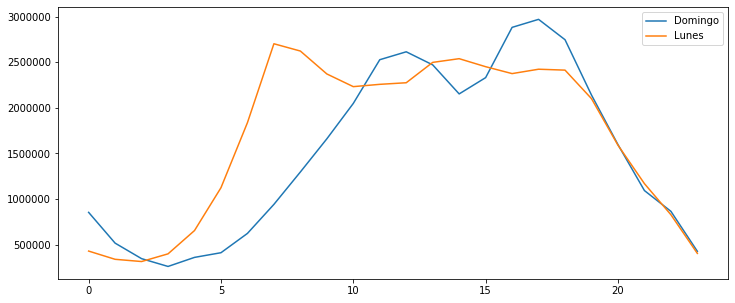

In [50]:
df.plot(figsize=(12,5));

Vamos a intentar a modelar la serie temporal utilizando la metodología de Holt-Winters. Empezamos por el suavizado exponencial simple. La libreria statsmodels va a calcular los valores ponderados que vamos a añadir a la tabla.


Cómo ya sabemos, la serie temporal tiene una estacionalidad, por lo cuál necesitamos aplicar el suavizado exponencial triple. 

In [60]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 24
alpha = 2/(span+1)

In [61]:
ts['SES24']=SimpleExpSmoothing(ts['movilidad']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
ts

,movilidad,SES24
2020-10-01 00:00:00,462730.538,4.627305e+05
2020-10-01 01:00:00,387049.918,4.566761e+05
2020-10-01 02:00:00,317706.331,4.455585e+05
2020-10-01 03:00:00,367035.598,4.392767e+05
2020-10-01 04:00:00,636404.198,4.550469e+05
...,...,...
2020-11-30 19:00:00,1767450.360,1.763039e+06
2020-11-30 20:00:00,1367525.670,1.731398e+06
2020-11-30 21:00:00,986590.410,1.671814e+06
2020-11-30 22:00:00,718019.963,1.595510e+06


Visualizamos los datos originales junto con los datos suavizados.

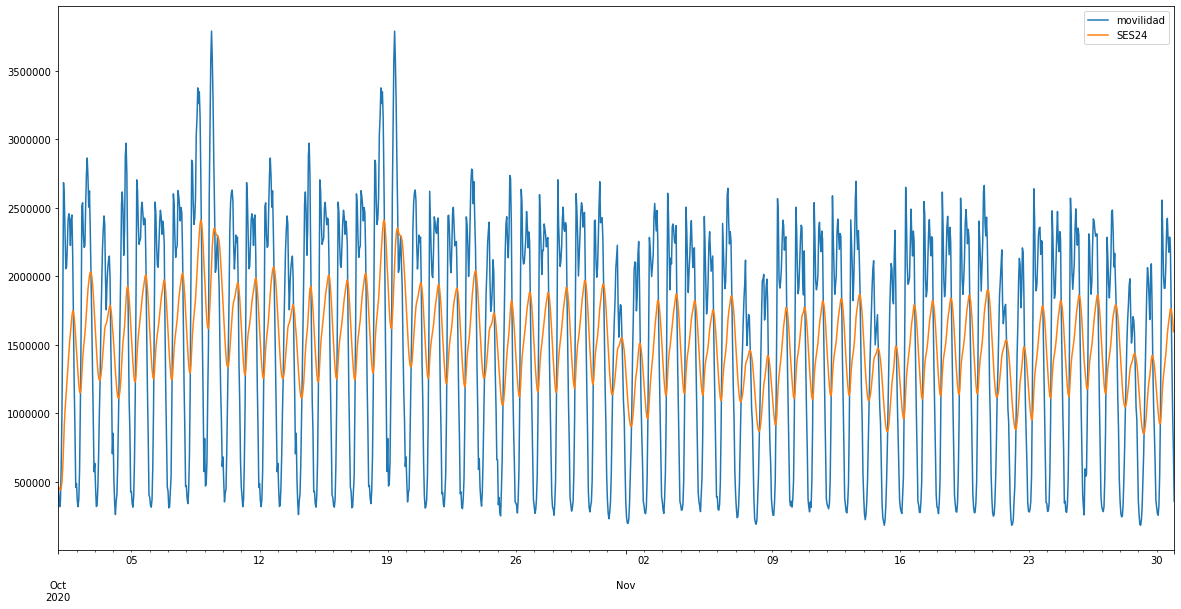

In [62]:
ts.plot();

Vemos que los valores suavizados están más bajos al comparar con valores originales. Intentamos a aplicar el método de suavizado exponencial doble.

In [63]:
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [70]:
ts['DES24'] = ExponentialSmoothing(ts['movilidad'], trend='add').fit().fittedvalues.shift(-1)
ts.head()

,movilidad,SES24,DES24
2020-10-01 00:00:00,462730.538,462730.538000,462730.538604
2020-10-01 01:00:00,387049.918,456676.088400,315940.019571
2020-10-01 02:00:00,317706.331,445558.507808,248256.067843
2020-10-01 03:00:00,367035.598,439276.675023,409191.190203
2020-10-01 04:00:00,636404.198,455046.876861,892050.296948


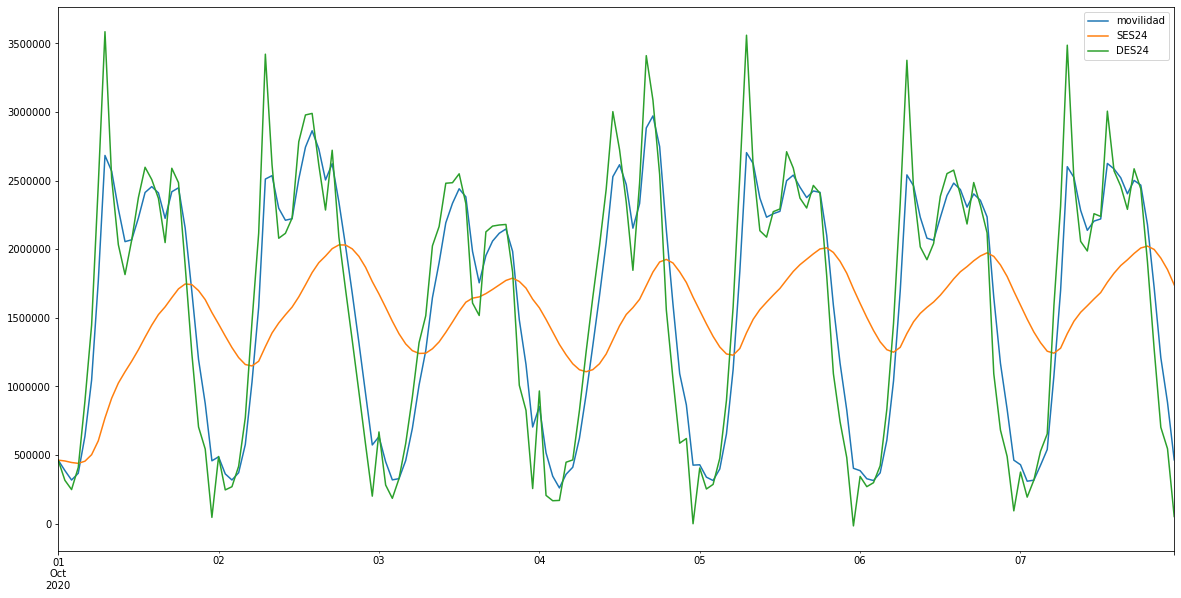

In [71]:
ts[:168].plot();

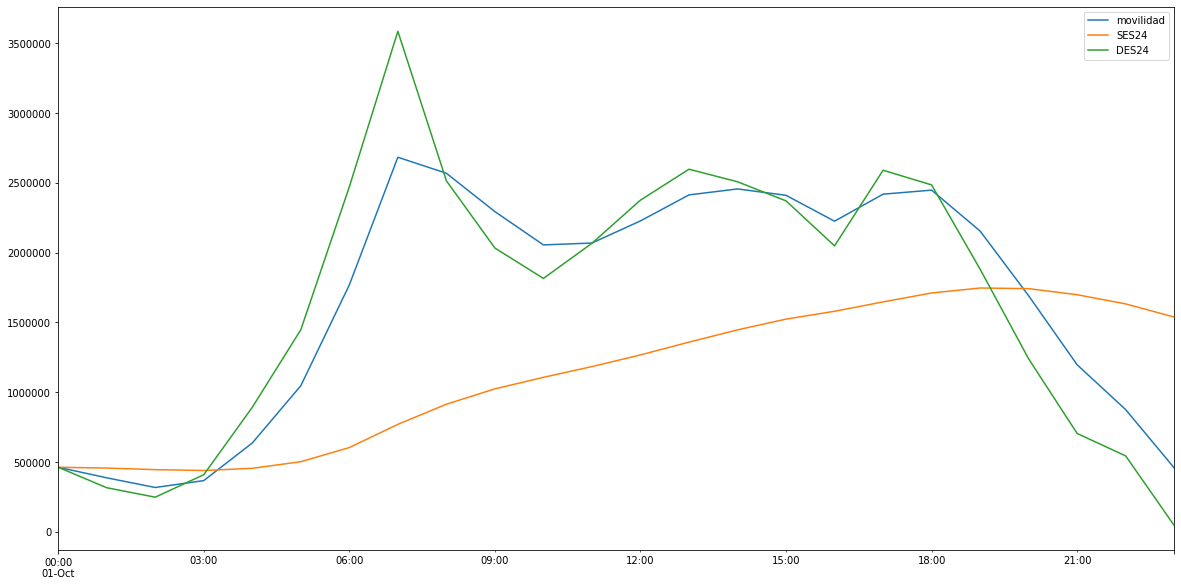

In [72]:
ts[:24].plot()

Aunque el suavizado doble funciona mejor que simple, intentamos a mejorar el modelo aplicando el suavizado exponencial triple.

In [77]:
ts['TES24'] = ExponentialSmoothing(ts['movilidad'],trend='add',seasonal='add',seasonal_periods=24).fit().fittedvalues
ts.head()

,movilidad,SES24,DES24,TES24
2020-10-01 00:00:00,462730.538,462730.538000,462730.538604,466218.516349
2020-10-01 01:00:00,387049.918,456676.088400,315940.019571,390193.071161
2020-10-01 02:00:00,317706.331,445558.507808,248256.067843,320556.465637
2020-10-01 03:00:00,367035.598,439276.675023,409191.190203,369964.562543
2020-10-01 04:00:00,636404.198,455046.876861,892050.296948,638600.434982


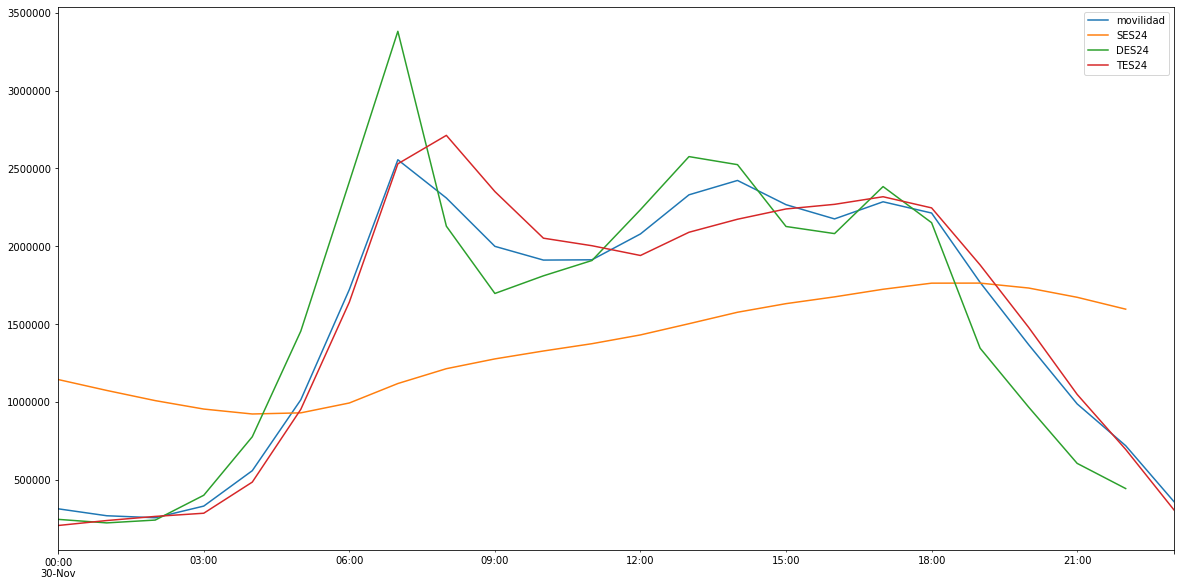

In [81]:
ts[-24:].plot();

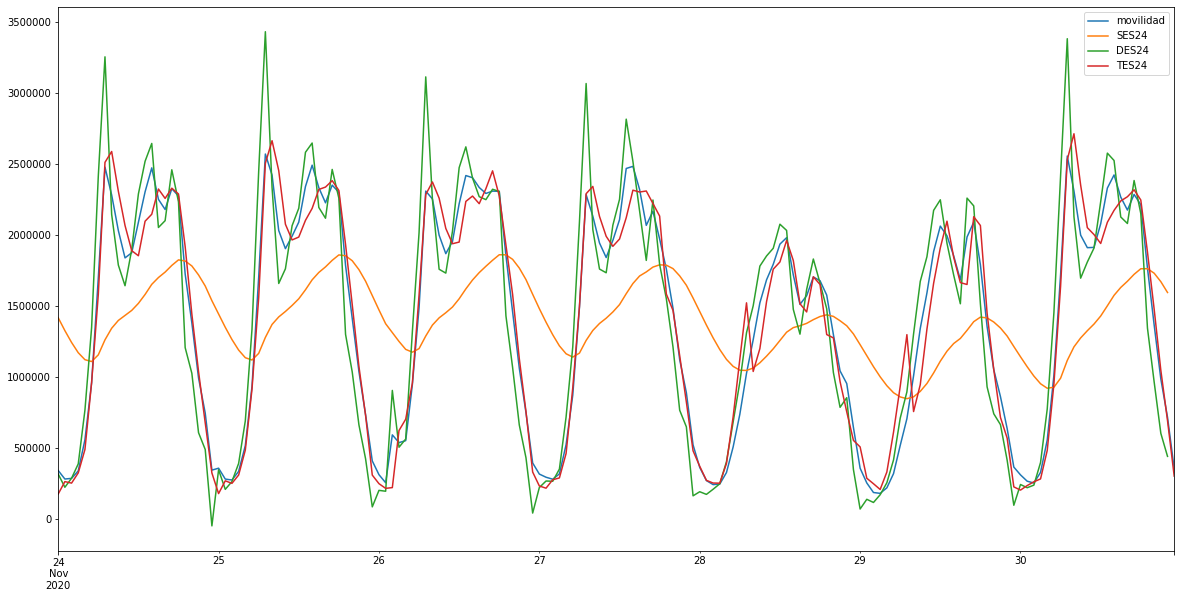

In [80]:
ts[-168:].plot();

Resulta que el suavizado triple nos da el mejor resultado, que no puede sorprender porque ya sabemos que los datos tienen una estacionalidad.

Ahora vamos a dividir los datos en dos partes: datos de entrenamiemto y de prueba. Entrenamos el modelo con datos de entrenamiento y hacemos una predición para los datos de prueba. Visualizamos los datos de prueba junto con las prediciones proporcionadas por el modelo. 

Intentamos utilizar como datos de entrenamiento todos los datos de octubre y noviembre menos la última semana de noviembre que va a servir cómo los datos de prueba.

In [98]:
train_data=ts['movilidad'][:-216]
test_data=ts['movilidad'][-216:]

In [99]:
model = ExponentialSmoothing(train_data, seasonal='add',seasonal_periods=24).fit()

In [100]:
predictions = model.forecast(216).rename('HW Forecast, 2 meses de datos')

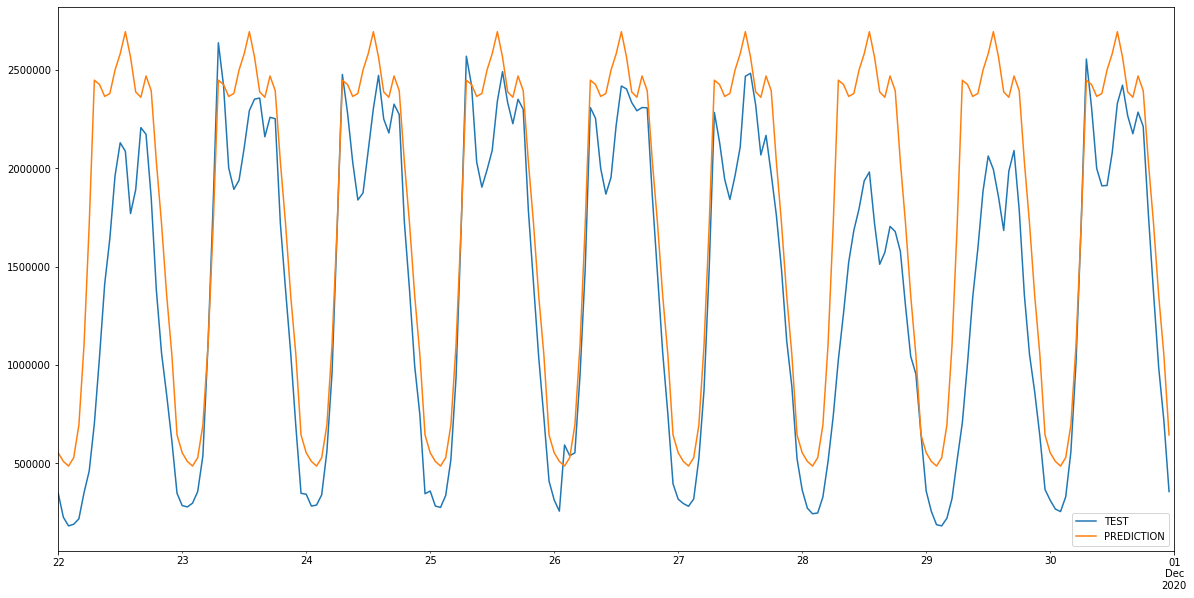

In [101]:
test_data.plot(legend=True,label='TEST')
predictions.plot(legend=True,label='PREDICTION', xlim=['2020-11-22','2020-12-01']);

Calculamos los errores de la predicción:

In [102]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_absolute_error(test_data,predictions)

369934.01352104876

In [103]:
np.sqrt(mean_squared_error(test_data,predictions))

475251.0133546285

Y ahora volvemos a entrenar el modelo utilizando sólo los datos de noviembre para ver si esto puede mejorar la predicción.

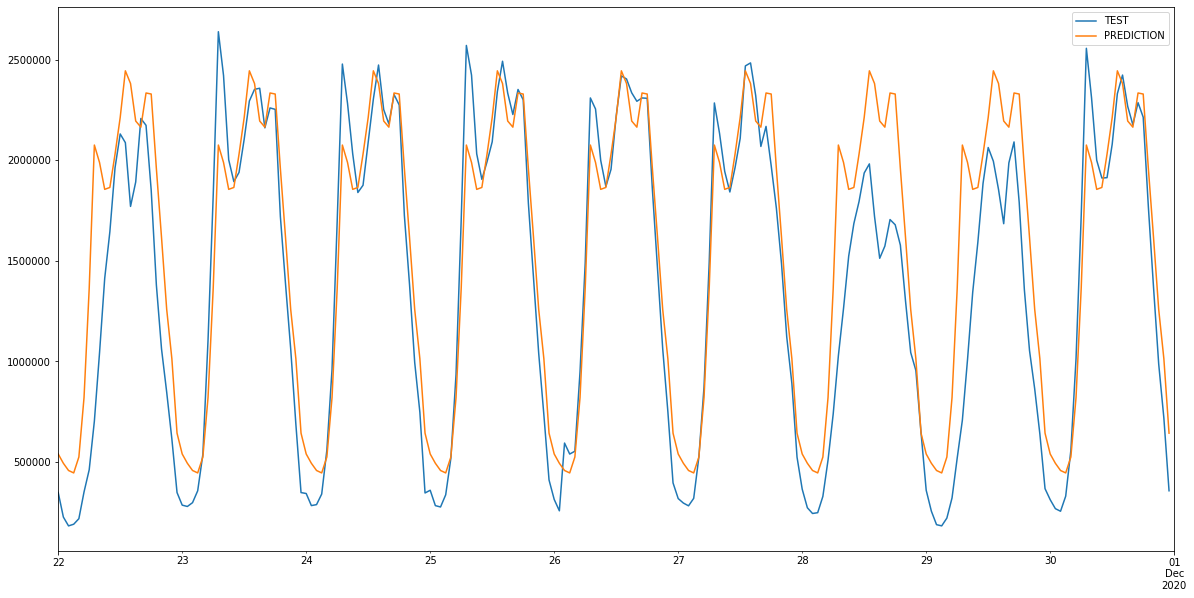

In [104]:
train_data=ts['movilidad'][744:-216]
test_data=ts['movilidad'][-216:]

model = ExponentialSmoothing(train_data, seasonal='add',seasonal_periods=24).fit()
predictions = model.forecast(216).rename('HW Forecast, 3 semanas de datos')

test_data.plot(legend=True,label='TEST')
predictions.plot(legend=True,label='PREDICTION', xlim=['2020-11-22','2020-12-01']);

In [105]:
mean_absolute_error(test_data,predictions)

246056.74684031084

In [106]:
np.sqrt(mean_squared_error(test_data,predictions))

331143.7406450296

Utilizando los datos más recientes hemos bajado el error de predicción significativamente. Así podemos concluir que para predecir el futuro comportamiento de series temporales los datos recientes valen mucho más que los datos históricos.